## Figure 1 Panel 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Read in all data
data = pd.read_csv("climate_conflict_replication/clim_conflict_for_R.csv")
area = pd.read_csv("climate_conflict_replication/croparea_weight.csv", encoding="windows-1252")
ssa = pd.read_csv("climate_conflict_replication/gseasSSA.csv")
cltol = pd.read_csv("climate_conflict_replication/precip_climatology.csv", index_col=0)
mss_country = pd.read_csv("climate_conflict_replication/mss_countries_new.csv", header=0)
mss_country.iloc[:, 0] = mss_country.iloc[:, 0].astype(str)
mss = mss_country.iloc[:, 0].unique().tolist()

In [4]:
#Import the altogether_montly array
altogether_monthly = np.load("altogether_monthly.npy")

In [5]:
#Generate projections of income and regime change to 2030.
#Income projections
ystart = data.loc[data["year_actual"] == 1981, data.columns[9]]
yend = data.loc[data["year_actual"] == 2002, data.columns[9]]

# Annual growth rate
ygro = np.exp(np.log(yend.values / ystart.values) / 21)

# Projections to 2030: using fixed 2% and historical median
median_yend = np.median(yend.dropna())
median_ygro = np.median(ygro[~np.isnan(ygro)])

incchg = np.array([
    median_yend * (1.02) ** 27,                          # Fixed 2% growth
    median_yend * (median_ygro) ** 27                    # Historical median growth
]) - median_yend

# Polity projections
polstart = data.loc[data["year_actual"] == 1981, data.columns[227]]
polend = data.loc[data["year_actual"] == 2002, data.columns[227]]

polchg = polend.values - polstart.values
pol2030 = polend.values + np.median(polchg[~np.isnan(polchg)])
pol2030 = np.clip(pol2030, None, 10)
polchg_final = np.mean(pol2030 - polend.values)

In [6]:
#Make area weights by region
mask = area.iloc[:, 1] != "Cereals,Total +"
for i in area[mask].index:
    # Find the corresponding cereal row in the top 42 rows with same country
    match = area.iloc[:42]
    match_idx = match[match.iloc[:, 0] == area.iloc[i, 0]].index
    if not match_idx.empty:
        area.at[i, area.columns[4]] = area.at[match_idx[0], area.columns[4]]

#Calculate unweighted area sums by region
unweight = []
for j in range(1, 6):  
    cond = (area.iloc[:, 1] == "land area") & (area.iloc[:, 4] == j)
    total = area.loc[cond, area.columns[3]].sum()
    unweight.append(total)

#Normalize
unweight = np.array(unweight)
unweight = unweight / unweight.sum()

In [7]:
#Climate model projections
clim = np.empty((6, 3, 2, 20))  # dims: region, model, variable (temp/precip), projection

#For temperature, averaging over monthly projected changes
k = 0
for i in range(5):       
    for j in range(3):  
        slice_ = altogether_monthly[i + 3, :, j, k, :20]  # (12 months x 20 projections)
        clim[i, j, k, :] = slice_.mean(axis=0)

#For precip, apply percentage changes to baseline climatatology, then compute total change in precip across months 
k = 1
for i in range(5):
    for j in range(3):
        for n in range(20):
            chg = altogether_monthly[i + 3, :, j, k, n] / 100 + 1
            clim[i, j, k, n] = (np.sum(cltol.iloc[i, :] * chg) / np.sum(cltol.iloc[i, :]) - 1) * 100 
for j in range(3):
    for k in range(2):
        for n in range(20):
            clim[5, j, k, n] = np.sum(clim[0:5, j, k, n] * unweight)
#Fixing an error where NaNs appear as -100 values
clim[clim == -100] = np.nan

/Users/davidkim/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/th/hwcvn4v50mzbrl3x2ftngk3w0000gn/T/ipykernel_39719/1190004525.py:16: RuntimeWarning: invalid value encountered in divide
  chg = altogether_monthly[i + 3, :, j, k, n] / 100 + 1


In [8]:
clim.shape

(6, 3, 2, 20)

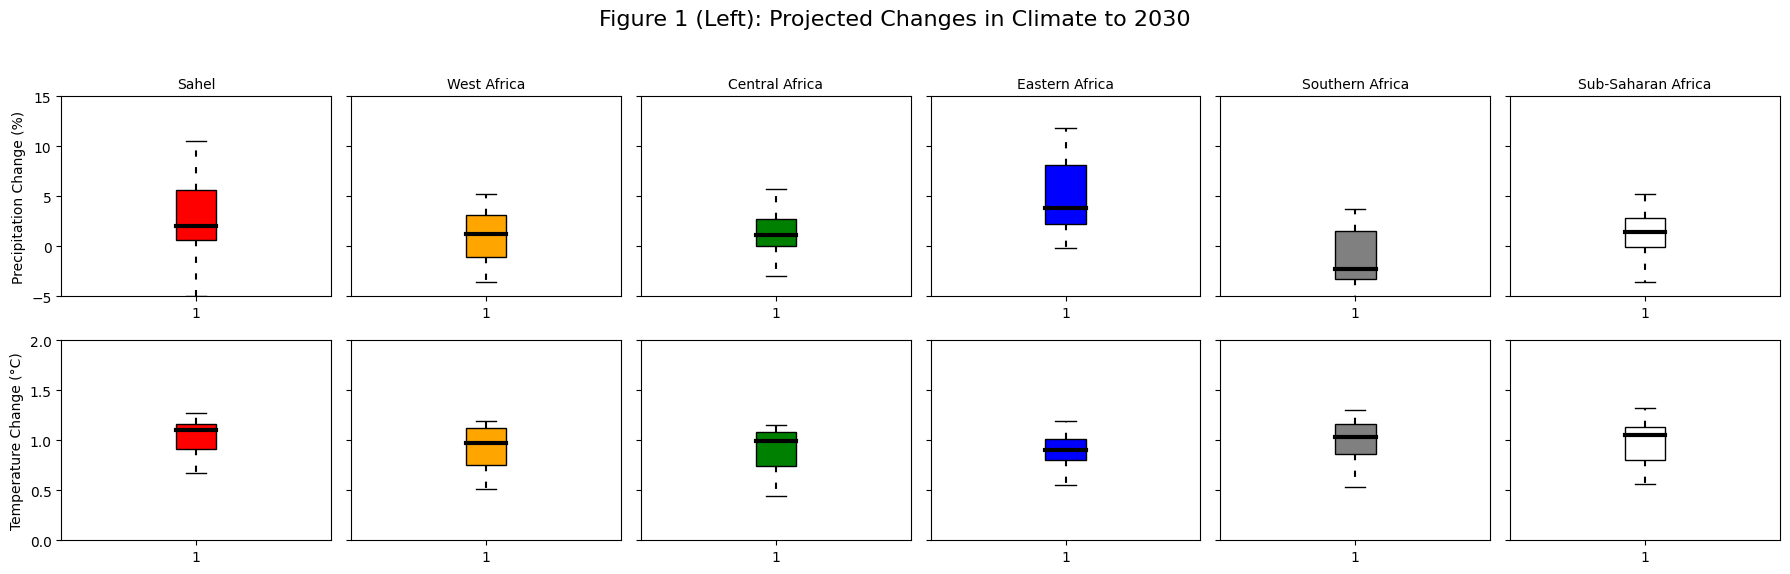

In [17]:
# --- Figure 1 Panel 1 ---
# - Boxplots for projected precipitation change (%) on top row
# - Boxplots for projected temperature change (°C) on bottom row
# - For 5 SSA regions + SSA-wide (6 total)

fig, axes = plt.subplots(2, 6, figsize=(18, 6), sharey='row')
regions = ["Sahel", "West Africa", "Central Africa", "Eastern Africa", "Southern Africa", "Sub-Saharan Africa"]
colors = ['red', 'orange', 'green', 'blue', 'grey', 'white']

# Top row: Precipitation Change (%)
for i, region in enumerate(regions):
    precip_clean = clim[i, 1, 1, :]
    precip_clean = precip_clean[~np.isnan(precip_clean)]
    axes[0, i].boxplot(precip_clean, 
                       patch_artist=True, 
                       boxprops=dict(facecolor=colors[i]), 
                       showfliers=False, 
                       medianprops=dict(color="black", linewidth=3), 
                       whiskerprops=dict(linestyle=(0, (3, 5)), color="black", linewidth=1.5))
    axes[0, i].set_title(region, fontsize=10)
    axes[0, i].set_ylim([-5, 15])
    if i == 0:
        axes[0, i].set_ylabel("Precipitation Change (%)")

# Bottom row: Temperature Change (°C)
for i, region in enumerate(regions):
    temp_clean = clim[i, 1, 0, :]
    temp_clean = temp_clean[~np.isnan(temp_clean)]
    axes[1, i].boxplot(temp_clean, 
                       patch_artist=True, 
                       boxprops=dict(facecolor=colors[i]), 
                       showfliers=False, 
                       medianprops=dict(color="black", linewidth=3),
                       whiskerprops=dict(linestyle=(0, (3, 5)), color="black", linewidth=1.5))
    axes[1, i].set_ylim([0, 2])
    if i == 0:
        axes[1, i].set_ylabel("Temperature Change (°C)")

plt.suptitle("Figure 1 (Left): Projected Changes in Climate to 2030", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Figure 2 Panel 2

In [19]:
# --- Figure 1 Panel 2 ---

#Visualization of one of the generated bootstraps
coefs_model_1 = pd.read_pickle('Bootstraps_David/bootstrap_df_1.pkl')
coefs_model_1

# Simulated OLS estimates for temp_all and temp_all_lag from Model 1
coefs_mean = np.array([coefs_model_1["temp_all"].mean(), coefs_model_1["temp_all_lag"].mean()])

#Coefs bootstrapped
coefs_boot = coefs_model_1[["temp_all", "temp_all_lag"]].to_numpy()

In [21]:
# Simulated temp projections per region (6 regions x 20 models)
temp_proj_models = clim[:, 1, 0, :]

temp_proj_models.shape

(6, 20)

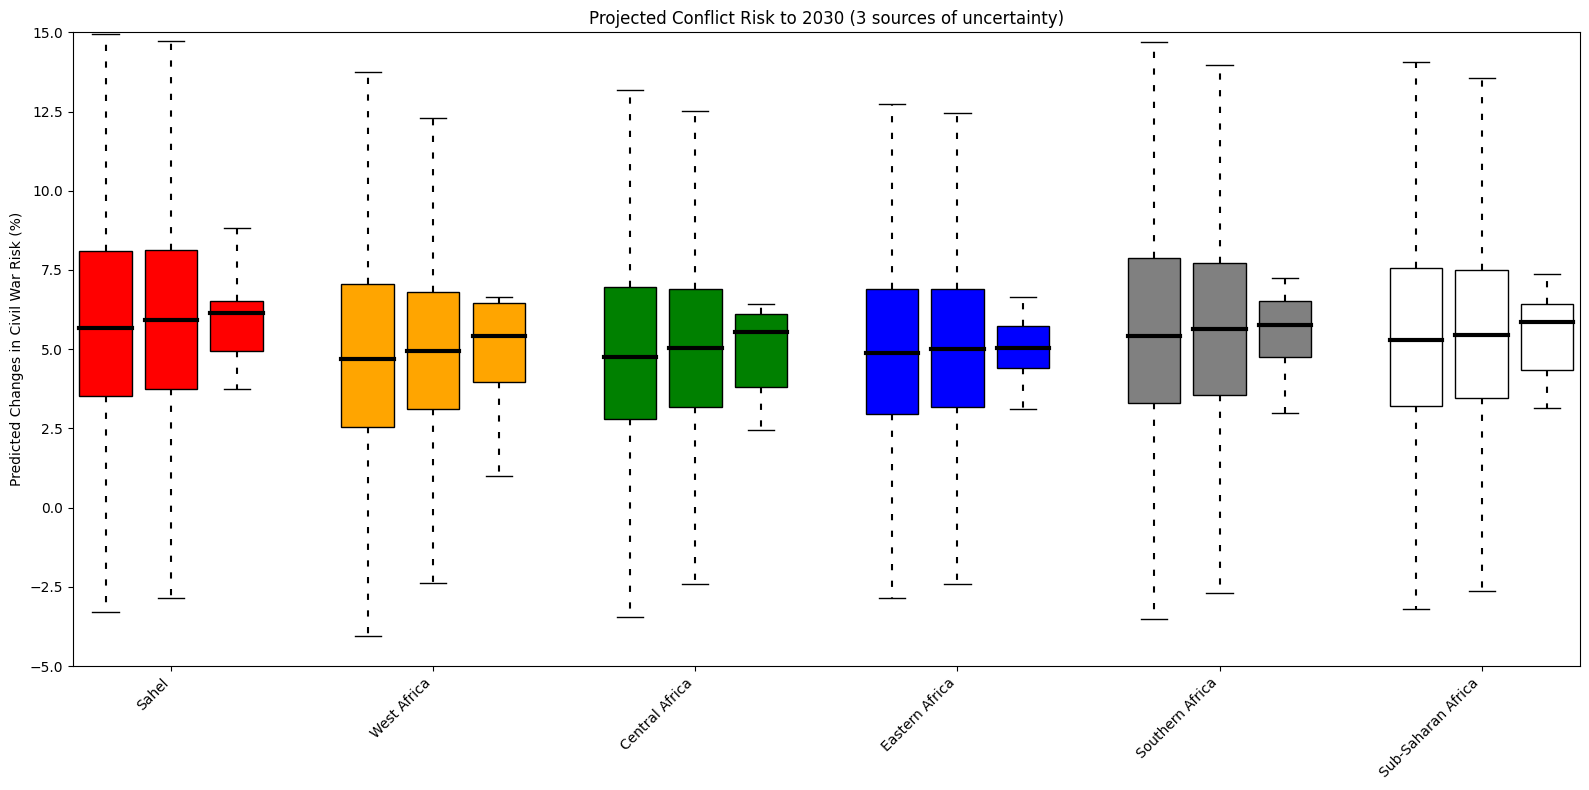

In [22]:
# --- Simulate all 3 boxplot scenarios ---
regions = ["Sahel", "West Africa", "Central Africa", "Eastern Africa", "Southern Africa", "Sub-Saharan Africa"]
colors = ['red', 'orange', 'green', 'blue', 'grey', 'white']
n_bootstrap = 10000

# Storage: per region
conflict_preds_full = []   # Full uncertainty
conflict_preds_conflict_only = []  # Conflict model uncertainty only
conflict_preds_climate_only = []   # Climate model uncertainty only

# For each region
for i in range(6):
    temp_proj = temp_proj_models[i, :]
    temp_proj = temp_proj[~np.isnan(temp_proj)]  # Clean NaN if any
    
    # Boxplot 1: Full uncertainty (sample both coefs and temps)
    preds_full = []
    for _ in range(n_bootstrap):
        coef = coefs_boot[np.random.choice(range(n_bootstrap))]
        temp = np.random.choice(temp_proj)
        pred = 100 * (coef[0] * temp + coef[1] * temp)
        preds_full.append(pred)
    conflict_preds_full.append(preds_full)
    
    # Boxplot 2: Conflict model uncertainty only (fixed temp)
    temp_mean = np.mean(temp_proj)
    preds_conflict = []
    for coef in coefs_boot:
        pred = 100 * (coef[0] * temp_mean + coef[1] * temp_mean)
        preds_conflict.append(pred)
    conflict_preds_conflict_only.append(preds_conflict)
    
    # Boxplot 3: Climate model uncertainty only (fixed coefs)
    preds_climate = []
    for temp in temp_proj:
        pred = 100 * (coefs_mean[0] * temp + coefs_mean[1] * temp)
        preds_climate.append(pred)
    preds_climate = np.random.choice(preds_climate, size=n_bootstrap, replace=True)
    conflict_preds_climate_only.append(preds_climate)

# --- Plot all 3 boxplots per region ---
fig, ax = plt.subplots(figsize=(16, 8))

positions = []
labels = []
data = []

# Collect data for grouped plotting
for i, region in enumerate(regions):
    base = i * 4
    positions.extend([base, base+1, base+2])
    labels.extend([region + " (full)", region + " (conflict)", region + " (climate)"])
    data.extend([
        conflict_preds_full[i],
        conflict_preds_conflict_only[i],
        conflict_preds_climate_only[i]
    ])

# Make boxplots
box = ax.boxplot(data, 
                 positions=positions, 
                 widths=0.8, 
                 patch_artist=True, 
                 showfliers= False, 
                 medianprops=dict(color="black", linewidth=3),
                 whiskerprops=dict(linestyle=(0, (3, 5)), color="black", linewidth=1.5))

# Color coding
for patch, color_idx in zip(box['boxes'], np.repeat(range(6), 3)):
    patch.set_facecolor(colors[color_idx])

ax.set_ylim(-5, 15)

ax.set_xticks([i * 4 + 1 for i in range(6)])
ax.set_xticklabels(regions, rotation=45, ha="right")
ax.set_ylabel("Predicted Changes in Civil War Risk (%)")
ax.set_title("Figure 1 (Right): Projected Conflict Risk to 2030 (3 sources of uncertainty)")

plt.tight_layout()
plt.show()
